In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import time
import os
from color_regions import ColorDatasetGenerator
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from scipy.interpolate import RegularGridInterpolator
import warnings
torch.backends.cudnn.benchmark = True
device = "cuda:0" if torch.cuda.is_available() else "cpu"

/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import sys
prev_time = 0
gamma = 0.99
stats = {}  # tracks ewma running average
def benchmark(point=None, profile=True, verbose=True, cuda=True): # not thread safe at all
    global prev_time
    if not profile:
        return
    if cuda:
        torch.cuda.synchronize()
    time_now = time.perf_counter()
    if point is not None:
        point = f"{sys._getframe().f_back.f_code.co_name}-{point}"
        time_taken = time_now - prev_time
        if point not in stats:
            stats[point] = time_taken
        stats[point] = stats[point]*gamma + time_taken*(1-gamma)
        if verbose:
            print(f"took {time_taken} to reach {point}, ewma={stats[point]}")
    prev_time = time_now

In [43]:
transform = transforms.Compose(
     [transforms.ToTensor()])#,
    #transforms.Normalize((0.5), (0.5))])

batch_size = 256  # seems to be the fastest batch size
train_indices = (0, 200_000) # size of training set
valid_indices = (1_250_000, 1_260_000)
test_indices = (260_000, 270_000)

def color_classifier(color):
    if color <= 100:  # medium difficulty (width = 75)
        return 0
    if 100 < color <= 150:  # hard difficulty (width = 50)
        return 1
    if 150 < color <= 200:  # hard difficulty (width = 50)
        return 2
    if 200 < color:  # hard difficulty (width = 50)
        return 1
critical_color_values = [100, 150, 200]

def set_loader_helper(indices):
    data_set = ColorDatasetGenerator(color_classifier=color_classifier,
                                    image_indices=indices,
                                    transform=transform,
                                    color_range=(25, 250),
                                    noise_size=(1,7),
                                    num_classes=3,
                                    size=128,
                                    radius=(128//6, 128//3))
    loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, 
                                          shuffle=True, num_workers=4, pin_memory=True)
    return data_set, loader
train_set, train_loader = set_loader_helper(train_indices)
valid_set, valid_loader = set_loader_helper(valid_indices)
test_set, test_loader = set_loader_helper(test_indices)

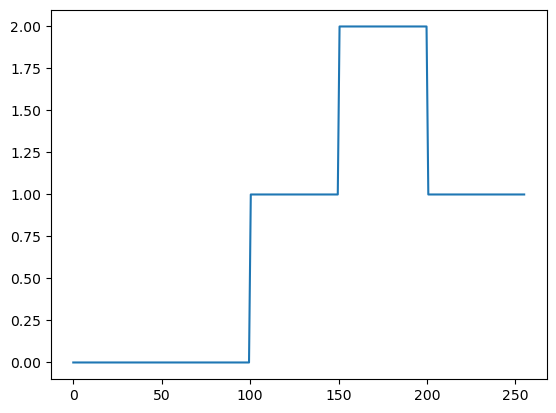

In [17]:
# the "medium" task
color_probe = np.linspace(0, 255, 255)
color_class = [color_classifier(x) for x in color_probe]
plt.plot(color_probe, color_class)

In [4]:
class ResNet(nn.Module):
    def __init__(self, conv_layers, num_classes, img_shape, path, fc_layers=[1000], groups=1):
        super().__init__()
        self.conv_layers1 = []  # entry into residual block 
        self.conv_layers2 = []  # https://arxiv.org/pdf/1512.03385.pdf Figure 3
        self.batch_norms1 = []
        self.batch_norms2 = []
        self.is_resid = []
        self.path = path
        self.num_classes = num_classes
        channels = img_shape[-1]
        img_size = img_shape[0]
        for l in conv_layers:  # (out_channels, kernel_size, stride) is each l
            if l[2] > 1: # stride
                pad_type = "valid"
                img_size = (img_size-l[1])//l[2] + 1 # https://arxiv.org/pdf/1603.07285.pdf
            else:
                pad_type = "same"
            if isinstance(l[0], float):
                l[0] = int(l[0])
                l[0] -= l[0] % groups # ensure divisble by groups
            self.is_resid.append(l[2] == 1 and channels == l[0])
            self.conv_layers1.append(nn.Conv2d(channels, l[0], l[1], stride=l[2], padding=pad_type, groups=groups))
            channels = l[0]
            self.final_num_logits = channels * img_size * img_size 
            self.batch_norms1.append(nn.BatchNorm2d(channels)) # cant use track_running_stats=False since
            self.batch_norms2.append(nn.BatchNorm2d(channels)) # it causes poor performance for inference with batch size=1 (or probably with the same image repeated a bunch of times)
            self.conv_layers2.append(nn.Conv2d(channels, channels, l[1], stride=1, padding="same", groups=groups))
        self.conv_layers1 = nn.ModuleList(self.conv_layers1)
        self.conv_layers2 = nn.ModuleList(self.conv_layers2)
        self.batch_norms1 = nn.ModuleList(self.batch_norms1)
        self.batch_norms2 = nn.ModuleList(self.batch_norms2)

        fully_connected = []
        fc_layers.insert(0, self.final_num_logits)
        fc_layers.append(num_classes)
        for fc_prev, fc_next in zip(fc_layers, fc_layers[1:]):
            fully_connected.append(nn.Linear(fc_prev, fc_next))
        self.fully_connected = nn.ModuleList(fully_connected)

    def forward(self, x, logits=False):
        network_iter = zip(self.conv_layers1, self.conv_layers2, self.batch_norms1, self.batch_norms2, self.is_resid)
        for i, (conv1, conv2, batch_norm1, batch_norm2, is_resid) in enumerate(network_iter):                
            x_conv1 = F.relu(batch_norm1(conv1(x)))
            x_conv2 = F.relu(batch_norm2(conv2(x_conv1)))
            if is_resid:
                x = x + x_conv2  # residual block
            else:
                x = x_conv2  # dimension increasing block            
        x = torch.flatten(x, 1)
        for i, fc_layer in enumerate(self.fully_connected):
            x = fc_layer(x)
            if i != len(self.fully_connected) - 1: # dont ReLU the last one
                x = F.relu(x)            
        if self.num_classes == 1 and not logits:  # always allow returning logits
            x = torch.sigmoid(x)
        return x    

    def num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def save_model_state_dict(self, path=None, optim=None):
        if path is None:
            path = self.path
        if optim is not None:
            save_dict = {}
            save_dict["model"] = self.state_dict()
            save_dict["optim"] = optim.state_dict()
        else:
            save_dict = self.state_dict()
        torch.save(save_dict, path)
    
    def load_model_state_dict(self, path=None, optim=None):
        if path is None:
            path = self.path
        if not os.path.exists(path):
            return
        load_dict = torch.load(path)
        if "model" in load_dict:
            if optim is not None:
                optim.load_state_dict(load_dict["optim"]) 
            self.load_state_dict(load_dict["model"])
        else:
            self.load_state_dict(load_dict)

In [11]:
def correct(pred_logits, labels):
    if labels.shape[1] != 1:
        pred_probabilities = F.softmax(pred_logits, dim=1)
        classifications = torch.argmax(pred_probabilities, dim=1)
        labels_argmax = torch.argmax(labels, dim=1)
    else:
        classifications = pred_logits.int()
        labels_argmax = labels
    correct = (labels_argmax == classifications)
    return correct

def train(net, optimizer, loss, epochs):
    va_losses = []
    tr_losses = []
    va_accuracies = []
    for epoch in range(epochs):
        epoch_tr_loss = 0.0
        net.train()
        for i, sample in tqdm(enumerate(train_loader)):
            imgs = sample["image"].to(device, non_blocking=False).float()
            labels = sample["label"].to(device).float()
            optimizer.zero_grad()
            outputs = net(imgs)
            batch_loss = loss(outputs, labels)
            epoch_tr_loss += batch_loss.item()
            batch_loss.backward()
            optimizer.step()
        epoch_va_loss = 0.0
        epoch_va_correct = 0
        net.eval()
        with torch.no_grad():
            for i, sample in enumerate(valid_loader):
                imgs = sample["image"].to(device).float()
                labels = sample["label"].to(device).float()
                outputs = net(imgs)
                epoch_va_loss += loss(outputs, labels).item()
                epoch_va_correct += correct(outputs, labels).sum().item()
        epoch_va_accuracy = epoch_va_correct/(valid_indices[1] - valid_indices[0])
        print(f'Epoch {epoch + 1}: va_loss: {epoch_va_loss}, va_accuracy: {epoch_va_accuracy}, tr_loss: {epoch_tr_loss}')
        if not va_losses or epoch_va_loss < min(va_losses):
            net.save_model_state_dict(optim=optimizer)
        va_losses.append(epoch_va_loss)
        tr_losses.append(epoch_tr_loss)
        va_accuracies.append(epoch_va_accuracy)
    return va_losses, va_accuracies, tr_losses

In [45]:
small_net = ResNet([[16, 3, 1],  # num_channels (input and output), kernel_size, stride
                    [32, 3, 1],
                    [64, 3, 8]], 3, [128, 128, 1], 
                   "unstrided_small_net_noise_medium_grey.dict", fc_layers=[32]).to(device)
loss_func = nn.CrossEntropyLoss()
small_optim = torch.optim.Adam(small_net.parameters())
print(small_net.num_params())
small_net.load_model_state_dict(optim=small_optim)

596659


In [44]:
results = train(small_net, small_optim, loss_func, 200)

782it [02:32,  5.14it/s]


Epoch 1: va_loss: 4.4367695748806, va_accuracy: 0.9557, tr_loss: 103.75272176414728


782it [02:32,  5.13it/s]


Epoch 2: va_loss: 10.850983433425426, va_accuracy: 0.9103, tr_loss: 77.67274215258658


782it [02:32,  5.13it/s]


Epoch 3: va_loss: 2.8137930538505316, va_accuracy: 0.9714, tr_loss: 81.51517249830067


782it [02:32,  5.12it/s]


Epoch 4: va_loss: 10.260336801409721, va_accuracy: 0.894, tr_loss: 73.51767801865935


782it [02:32,  5.11it/s]


Epoch 5: va_loss: 51.46814274787903, va_accuracy: 0.8219, tr_loss: 71.25996474549174


782it [02:32,  5.11it/s]


Epoch 6: va_loss: 13.115911200642586, va_accuracy: 0.8902, tr_loss: 69.0909947194159


782it [02:32,  5.11it/s]


Epoch 7: va_loss: 51.18436050415039, va_accuracy: 0.7536, tr_loss: 67.19520504958928


782it [02:33,  5.11it/s]


Epoch 8: va_loss: 5.264064699411392, va_accuracy: 0.9427, tr_loss: 67.79935001768172


782it [02:33,  5.11it/s]


Epoch 9: va_loss: 2.9149888269603252, va_accuracy: 0.9625, tr_loss: 64.90707852877676


782it [02:33,  5.11it/s]


Epoch 10: va_loss: 5.009447202086449, va_accuracy: 0.9503, tr_loss: 65.49041960388422


782it [02:33,  5.11it/s]


Epoch 11: va_loss: 4.069841869175434, va_accuracy: 0.9504, tr_loss: 59.40713891945779


782it [02:33,  5.11it/s]


Epoch 12: va_loss: 6.306719057378359, va_accuracy: 0.9286, tr_loss: 60.62975246831775


782it [02:33,  5.11it/s]


Epoch 13: va_loss: 13.451179280877113, va_accuracy: 0.8991, tr_loss: 60.07134388945997


782it [02:33,  5.11it/s]


Epoch 14: va_loss: 1.6625650767236948, va_accuracy: 0.9864, tr_loss: 59.99821619875729


782it [02:33,  5.11it/s]


Epoch 15: va_loss: 1.7810337929986417, va_accuracy: 0.9814, tr_loss: 60.587764324620366


782it [02:33,  5.10it/s]


Epoch 16: va_loss: 2.0870641581714153, va_accuracy: 0.9812, tr_loss: 58.22442169487476


782it [02:33,  5.10it/s]


Epoch 17: va_loss: 7.355371303856373, va_accuracy: 0.937, tr_loss: 57.31447002571076


782it [02:33,  5.10it/s]


Epoch 18: va_loss: 19.297174245119095, va_accuracy: 0.9115, tr_loss: 54.53800865635276


782it [02:33,  5.10it/s]


Epoch 19: va_loss: 3.985773093998432, va_accuracy: 0.955, tr_loss: 56.67264663055539


782it [02:33,  5.10it/s]


Epoch 20: va_loss: 24.718753188848495, va_accuracy: 0.8707, tr_loss: 51.83631834760308


782it [02:33,  5.10it/s]


Epoch 21: va_loss: 7.271973326802254, va_accuracy: 0.9239, tr_loss: 50.00780953001231


782it [02:33,  5.10it/s]


Epoch 22: va_loss: 1.5718468483537436, va_accuracy: 0.9856, tr_loss: 51.00011870265007


782it [02:33,  5.10it/s]


Epoch 23: va_loss: 3.262919081375003, va_accuracy: 0.9638, tr_loss: 50.656044306233525


782it [02:33,  5.11it/s]


Epoch 24: va_loss: 3.2123836055397987, va_accuracy: 0.9594, tr_loss: 49.18498214054853


782it [02:33,  5.10it/s]


Epoch 25: va_loss: 4.2201456017792225, va_accuracy: 0.9447, tr_loss: 47.45994571223855


104it [00:20,  5.06it/s]


KeyboardInterrupt: 

In [18]:
@torch.no_grad()
def rate_distribution(net, loader, dataset, buckets=100):
    net.eval()
    total = np.zeros((buckets))
    num_correct = np.zeros((buckets))
    num_possible_colors = dataset.color_range[1] - dataset.color_range[0]
    for sample in tqdm(loader):
        imgs = sample["image"].to(device).float()
        labels = sample["label"].to(device).float()
        actual_colors = sample["color"]
        color_indices = (buckets * (actual_colors - dataset.color_range[0]) / num_possible_colors).int().numpy()
        outputs = net(imgs)
        correct_preds = correct(outputs, labels).cpu().numpy()
        for i, color_idx in enumerate(color_indices):
            total[color_idx] += 1  
            num_correct[color_idx] += correct_preds[i]
    return num_correct, total
_num_correct, _total = rate_distribution(small_net, valid_loader, valid_set)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.52it/s]


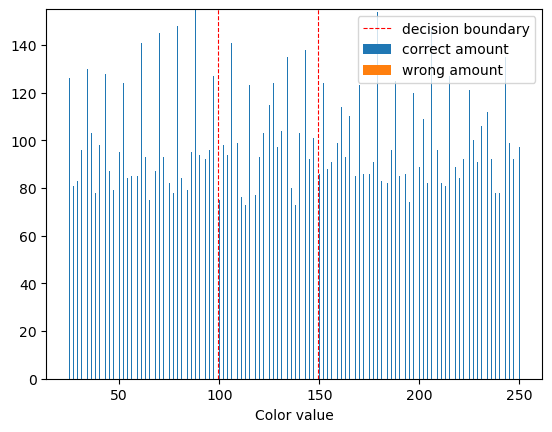

In [19]:
def make_graph(num_correct, total, dataset, critical_values=[150-0.5], buckets=100):
    num_wrong = total - num_correct
    width = 0.4
    labels = [int(x) for i, x in enumerate(np.linspace(*dataset.color_range, buckets))]
    plt.bar(labels, num_correct, width, label="correct amount")
    plt.bar(labels, num_wrong, width, bottom=num_correct, label="wrong amount")
    plt.vlines(critical_values, 0, np.max(total), linewidth=0.8,
               colors="r", label="decision boundary",
               linestyles="dashed")
    plt.legend()
    plt.xlabel("Color value")
    plt.show()
make_graph(_num_correct, _total, valid_set,   # with .eval(), looks good
           critical_values=[100-0.5, 150-0.5])  # => regions of ~40+ pixel values learnable?

In [46]:
small_net.eval() # very important!
with torch.no_grad():
    test_index = 987_652  # results seem pretty dependent on image, especially in small-color regimes
    counterfactual_color_values = np.linspace(0, 255, 255) # probably because bad batchnorm estimates
    responses = []
    for color in counterfactual_color_values:
        np.random.seed(test_index)
        generated_img, lbl, *__ = valid_set.generate_one(set_color=color)
        generated_img = np.expand_dims(generated_img, 0).transpose(0, 3, 1, 2)
        generated_img = torch.tensor(generated_img).to(device).float()
        response = small_net(torch.tensor(generated_img).to(device).float(), logits=True).cpu().numpy()
        responses.append(np.squeeze(response))

/tmp/ipykernel_441150/4095744600.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  response = small_net(torch.tensor(generated_img).to(device).float(), logits=True).cpu().numpy()


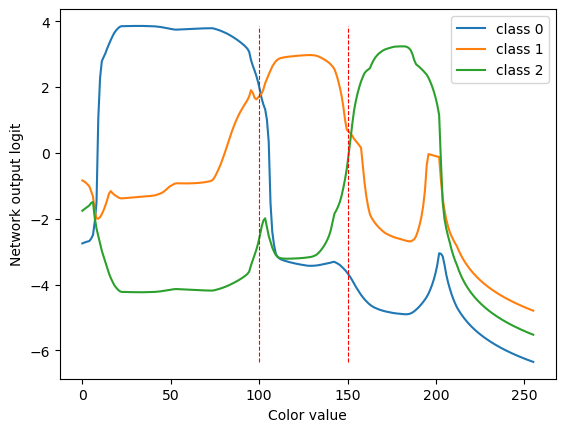

In [47]:
responses = np.arcsinh(np.array(responses))
for output_logit in range(responses.shape[1]):
    plt.plot(counterfactual_color_values, responses[:, output_logit], label=f"class {output_logit}")
plt.legend()
plt.xlabel("Color value")
plt.ylabel("Network output logit")
plt.vlines([100, 150], np.min(responses), np.max(responses), linewidth=0.8,
           colors="r", label="decision boundary",
           linestyles="dashed") # with .eval() works well

In [26]:
# to further test the "using 1 image => bad batchnorm estimates" lets do the same test
# but instead we will average over a sample of responses
small_net.eval() # very important!
stack_size = 32
sampled_indices = 1_250_000 + np.random.choice(1000, stack_size, replace=False)
total_images = stack_size * 255
correct_num = 0
with torch.no_grad():
    counterfactual_color_values = np.linspace(0, 255, 255)
    responses = []
    for color in tqdm(counterfactual_color_values):
        stacked_generated_img = []
        for sampled_index in sampled_indices:
            np.random.seed(sampled_index)
            generated_img, lbl, *__ = valid_set.generate_one(set_color=color)
            stacked_generated_img.append(generated_img)
        stacked_generated_img = np.array(stacked_generated_img).transpose(0, 3, 1, 2)
        generated_img = torch.tensor(stacked_generated_img).to(device).float()
        response = small_net(generated_img, logits=True)
        stacked_lbl = torch.tensor(np.repeat(np.expand_dims(lbl, 0), stack_size, axis=0)).to(device)
        correct_num += correct(response, stacked_lbl).sum()
        responses.append(np.squeeze(response.cpu().numpy()).mean(axis=0))
print(correct_num/total_images, "total accuracy")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 72.52it/s]

tensor(0.9771, device='cuda:0') total accuracy


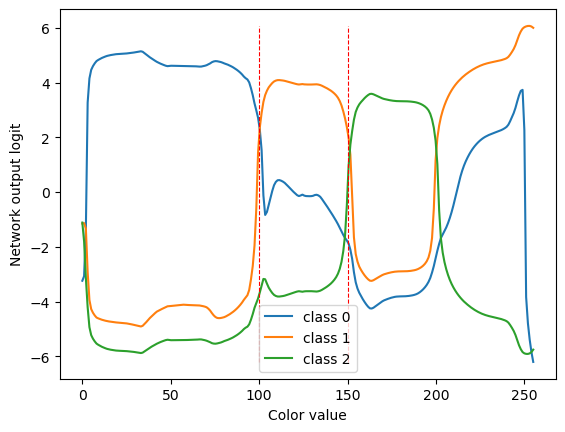

In [27]:
responses = np.arcsinh(np.array(responses))  # this graph is quite robust to changes in batch size
for output_logit in range(responses.shape[1]): # if we do .eval(), but varies if we do .train()
    plt.plot(counterfactual_color_values, responses[:, output_logit], label=f"class {output_logit}")
plt.legend()
plt.xlabel("Color value")
plt.ylabel("Network output logit")
plt.vlines([100, 150], np.min(responses), np.max(responses), linewidth=0.8,
           colors="r", label="decision boundary", # probably because .train() in this case actually gives biased estimates because all the colors are the same
           linestyles="dashed")  # logit graphs look bad if doing .train(), and accuracy is lower?

In [265]:
res_net.eval()   # ---> without this line, it fails, especially with small colors
with torch.no_grad():  # => batchnorm updates are very inaccurate if just one image
    idx = 1_250_026   # => network expects batchnorm updates to basically be exactly in the "middle" 127
    print(valid_set[idx])  # => fix the logit response graph by requiring it to be in eval mode
    print(torch.softmax(res_net(torch.unsqueeze(valid_set[idx]["image"], 0).to(device).float()), 1))

{'image': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float64), 'label': array([0., 0., 1.]), 'color': array([[211]])}
tensor([[0., 0., 1.]], device='cuda:0')


In [275]:
# to test the above hypothesis, if we just stack the same image a bunch of times, and do .train()
# the estimates should still be bad because batchnorm estimates would be just as bad as with 
# a single image in the batch
res_net.train()
idx = 1_250_024  # => hypothesis seems to be confirmed
test_image = valid_set[idx]["image"].numpy()
stacked_test = np.repeat(np.expand_dims(test_image, 0), 32, axis=0)
print(valid_set[idx])
print(torch.softmax(res_net(torch.tensor(stacked_test).to(device).float()), 1)[0])

{'image': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float64), 'label': array([1., 0., 0.]), 'color': array([[47]])}
tensor([0., 0., 1.], device='cuda:0', grad_fn=<SelectBackward0>)


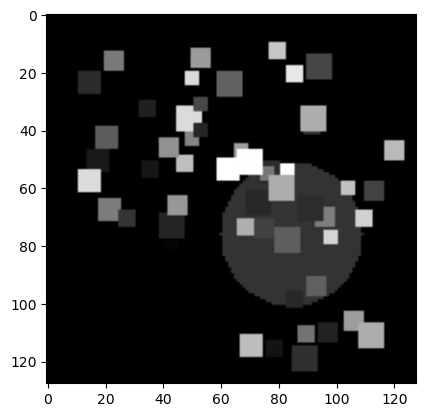

In [126]:
plt.imshow(np.squeeze(generated_img.cpu().numpy()), cmap="gray")

In [258]:
res_net.train()
with torch.no_grad():
    for i, sample in enumerate(valid_loader):
        imgs = sample["image"].to(device).float()
        labels = sample["label"].to(device).float()
        print(sample["color"])
        outputs = res_net(imgs)
        print(loss_func(outputs, labels).item())
        print(torch.argmax(labels,dim=1), torch.argmax(outputs, dim=1))
        print(correct(outputs, labels).sum().item())
        break

tensor([[[201]],

        [[ 66]],

        [[118]],

        [[ 41]],

        [[ 93]],

        [[209]],

        [[229]],

        [[159]],

        [[ 76]],

        [[202]],

        [[216]],

        [[223]],

        [[210]],

        [[ 85]],

        [[127]],

        [[124]],

        [[100]],

        [[224]],

        [[214]],

        [[163]],

        [[246]],

        [[ 58]],

        [[201]],

        [[ 52]],

        [[117]],

        [[ 82]],

        [[223]],

        [[244]],

        [[ 91]],

        [[147]],

        [[114]],

        [[180]]])
0.04659534990787506
tensor([2, 0, 1, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 1, 1, 0, 2, 2, 2, 2, 0, 2, 0,
        1, 0, 2, 2, 0, 1, 1, 2], device='cuda:0') tensor([2, 0, 1, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 1, 1, 1, 2, 2, 2, 2, 0, 2, 0,
        1, 0, 2, 2, 0, 1, 1, 2], device='cuda:0')
31


In [48]:
@torch.no_grad()
def finite_differences(model, dataset, target_class, stacked_img, locations, channel, unfairness, values_prior):
    num_iters = 20 # sample 20 values evenly spaced
    cuda_stacked_img = torch.tensor(stacked_img).to(device)
    if dataset.num_classes == 2:
        class_multiplier = 1 if target_class == 1 else -1 
        baseline_activations = class_multiplier*model(cuda_stacked_img, logits=True)
    else:
        baseline_activations = model(cuda_stacked_img)[:, target_class]
    largest_slope = np.zeros(stacked_img.shape[0])  # directional finite difference?
    slices = np.index_exp[np.arange(stacked_img.shape[0]), channel, locations[:, 0], locations[:, 1]]
    if values_prior is None:
        values_prior = np.linspace(5, 250, stacked_img.shape[0]) # uniform distribution assumption
    elif isinstance(values_prior, list):
        values_prior = np.expand_dims(np.asarray(values_prior), 1)
    num_loops = 1 if unfairness == "very unfair" else len(values_prior)
    for i in range(num_loops):
        shift_img = stacked_img.copy()
        # shifting method
        if unfairness in ["fair", "unfair"]:
            shift_img[slices] = values_prior[i]+0.01  # add tiny offset to "guarantee" non-zero shift
        elif unfairness in ["very unfair"]:
            critical_value_dists = shift_img[slices] - values_prior
            closest = np.argmin(abs(critical_value_dists), axis=0) # find closest class boundary
            shift_img[slices] = 0.01 + np.choose(closest, values_prior) - 10*np.sign(np.choose(closest, critical_value_dists))
        
        actual_diffs = shift_img[slices] - stacked_img[slices]  
        img_norm = torch.tensor(shift_img).to(device) # best is no normalization anyway
        if dataset.num_classes == 2:
            activations = class_multiplier*model(img_norm, logits=True)
        else:
            activations = model(img_norm)[:, target_class]
        activation_diff = (activations - baseline_activations).cpu().numpy().squeeze()
        finite_difference = np.clip(activation_diff/actual_diffs, -30, 30) # take absolute slope
        largest_slope = np.where(abs(finite_difference) > abs(largest_slope), finite_difference, largest_slope)
    return largest_slope      

def finite_differences_map(model, dataset, target_class, img, unfairness="fair", values_prior=None):
    # generate a saliency map using finite differences method (iterate over colors)
    model.eval()
    batch_size = 32  # check batch_size num pixel positions in parallel
    im_size = dataset.size
    #img = img.astype(np.float32)/255. # normalization handled later
    values_x = np.repeat(np.arange(im_size), im_size)
    values_y = np.tile(np.arange(im_size), im_size)
    indices = np.stack((values_x, values_y), axis=1)
    stacked_img = np.repeat(np.expand_dims(img, 0), batch_size, axis=0)
    stacked_img = np.transpose(stacked_img, (0, 3, 1, 2)).astype(np.float32) # NCHW format
    img_heat_map = np.zeros_like(img)
    for channel in range(dataset.channels):
        for k in tqdm(range(0, im_size*im_size, batch_size)):
            actual_batch_size = min(batch_size, im_size*im_size-k+batch_size)
            locations = indices[k:k+batch_size]
            largest_slopes = finite_differences(model, dataset, target_class, stacked_img, locations, channel, unfairness, values_prior)
            img_heat_map[locations[:,0], locations[:,1], channel] = largest_slopes
    return img_heat_map#.sum(axis=2)  # linear approximation aggregation?

In [61]:
def plt_grid_figure(grid, titles=None, colorbar=True, cmap=None, transpose=False, hspace=-0.4):      
    np_grid = np.array(grid).squeeze()
    if len(np_grid.shape) != 4:
        np_grid = np.expand_dims(np_grid, 0)
    if transpose:
        np_grid = np_grid.transpose(1,0,2,3)
        
    if cmap is None:
        cmap = "bwr"
    nrows, ncols = np_grid.shape[0], np_grid.shape[1]
    im_size = np_grid.shape[2]
    print(np_grid.shape, nrows, ncols)
    fig = plt.figure(figsize=(4/128*im_size*ncols, 5/128*im_size*nrows))
    gridspec = fig.add_gridspec(nrows, ncols, hspace=hspace)
    axes = gridspec.subplots(sharex="col", sharey="row")
    if len(axes.shape) == 1:
        axes = np.expand_dims(axes, 0)
    for i, row in enumerate(np_grid):
        for j, img in enumerate(row):
            if j == 0: # assume explain_img is the first thing
                im = axes[i,j].imshow(img, cmap="gray")
            else:
                img_max = np.max(abs(img))
                if cmap != "gray":
                    im = axes[i,j].imshow(img, cmap=cmap, interpolation="nearest", vmax=img_max, vmin=-img_max)
                else:
                    axes[i,j].imshow(img, cmap=cmap)
                if colorbar:
                    plt.colorbar(im, pad=0, fraction=0.048)
            if titles and i == 0:
                axes[i,j].set_title(titles[j])
    plt.show()

In [50]:
np.random.seed(500_001)
explain_img, lbl, *_ = valid_set.generate_one()
heat_map = finite_differences_map(small_net, valid_set, lbl.argmax(), explain_img)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [01:53<00:00,  4.51it/s]


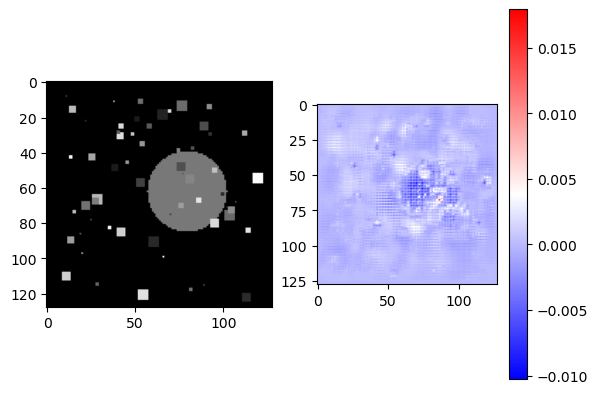

In [34]:
plt.subplot(1, 2, 1)
plt.imshow(explain_img, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(heat_map, cmap="bwr", interpolation="bilinear")
plt.colorbar()
# generated with strides = 2 everywhere

(1, 2, 128, 128) 1 2


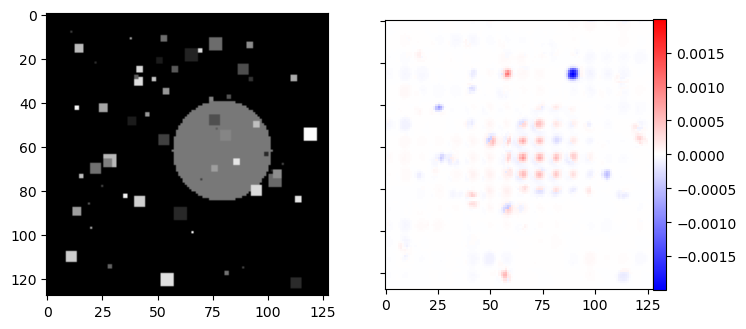

In [53]:
plt_grid_figure([explain_img, heat_map], transpose=False, colorbar=True)
# generated with strides = 1, strides = 8 for lats layer

In [54]:
image_ids = [20_000, 25_000, 30_000, 600_000, 600_001]
heat_maps = []
explain_imgs = []
for i, image_id in enumerate(image_ids):
    np.random.seed(image_id)
    explain_img_i, target_i, *__ = valid_set.generate_one()
    heat_map_i = finite_differences_map(small_net, valid_set, target_i.argmax(), explain_img_i)
    heat_maps.append(heat_map_i)
    explain_imgs.append(explain_img_i)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [01:55<00:00,  4.43it/s]


(5, 2, 128, 128) 5 2


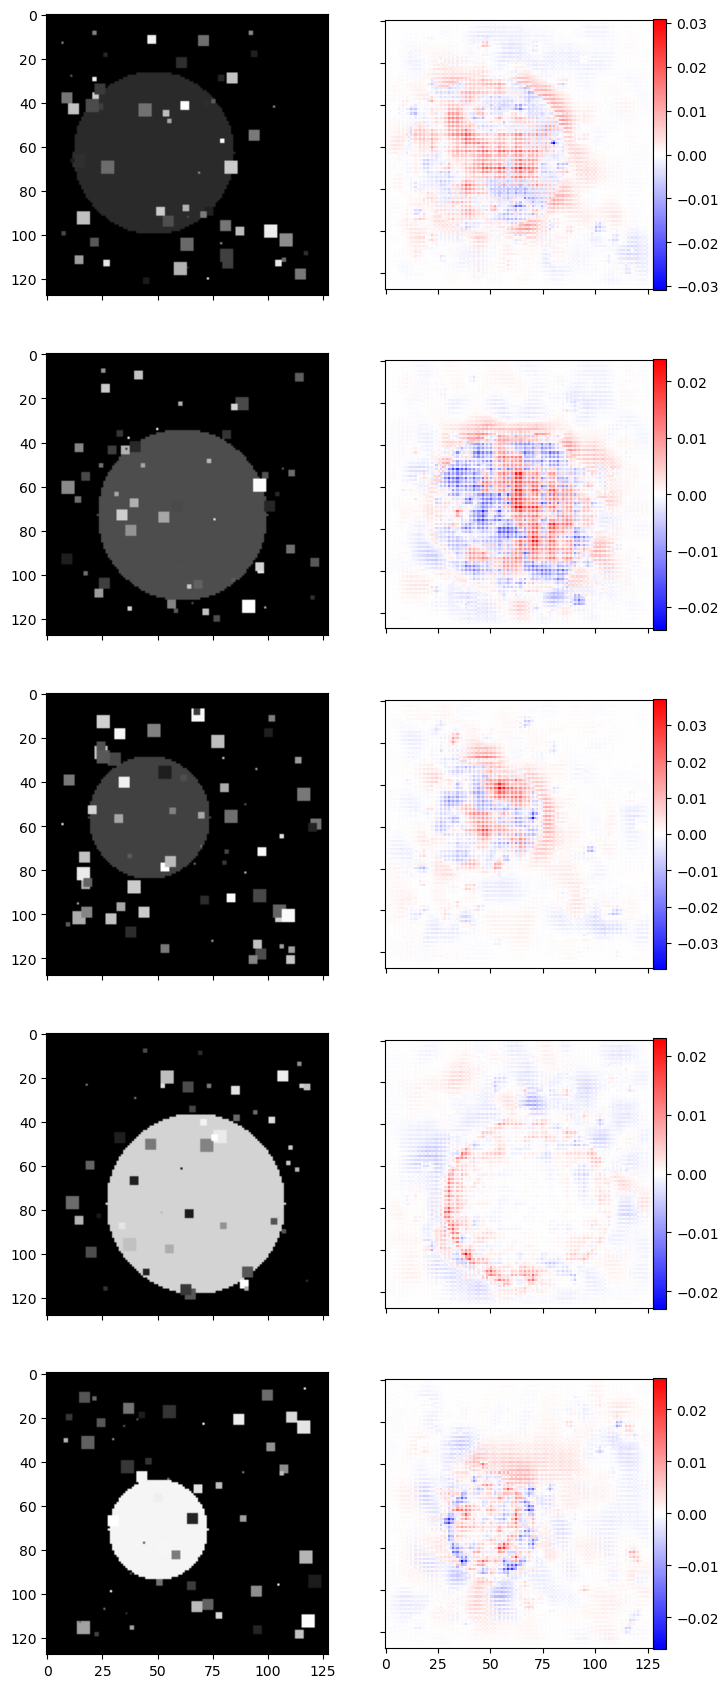

In [38]:
plt_grid_figure([explain_imgs, heat_maps], transpose=True, colorbar=True)
# generated with strides=2 everywhere

(5, 2, 128, 128) 5 2


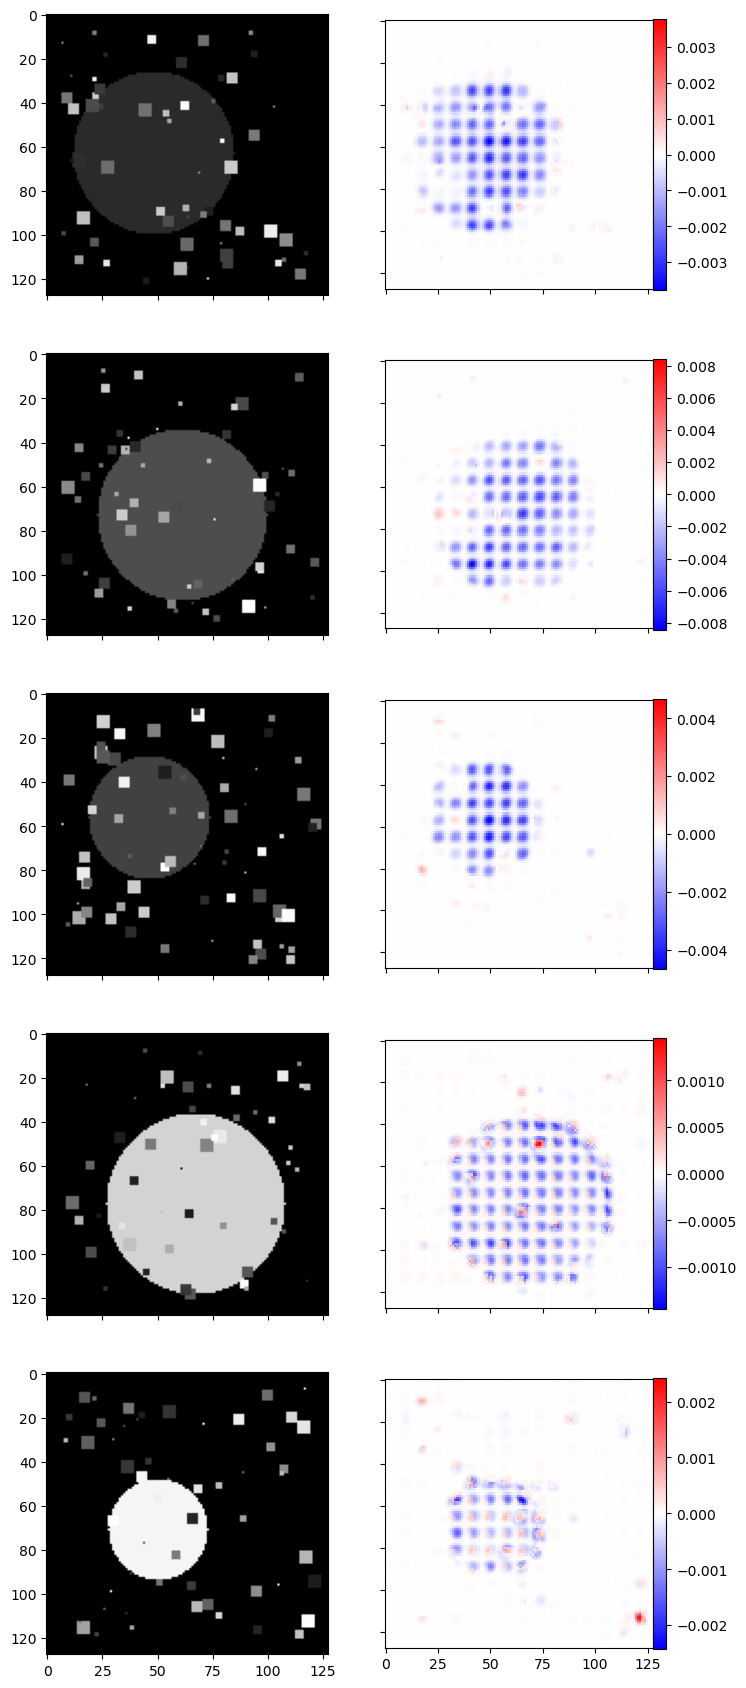

In [55]:
plt_grid_figure([explain_imgs, heat_maps], transpose=True, colorbar=True)
# generated with strides = 1, strides = 8 for lats layer

What if we run the same experiment, but cheat with a prior on pixel values that we know *should* be informative to the output logit, namely values closest to the decision boundary?

100%|██████████| 512/512 [01:55<00:00,  4.44it/s]


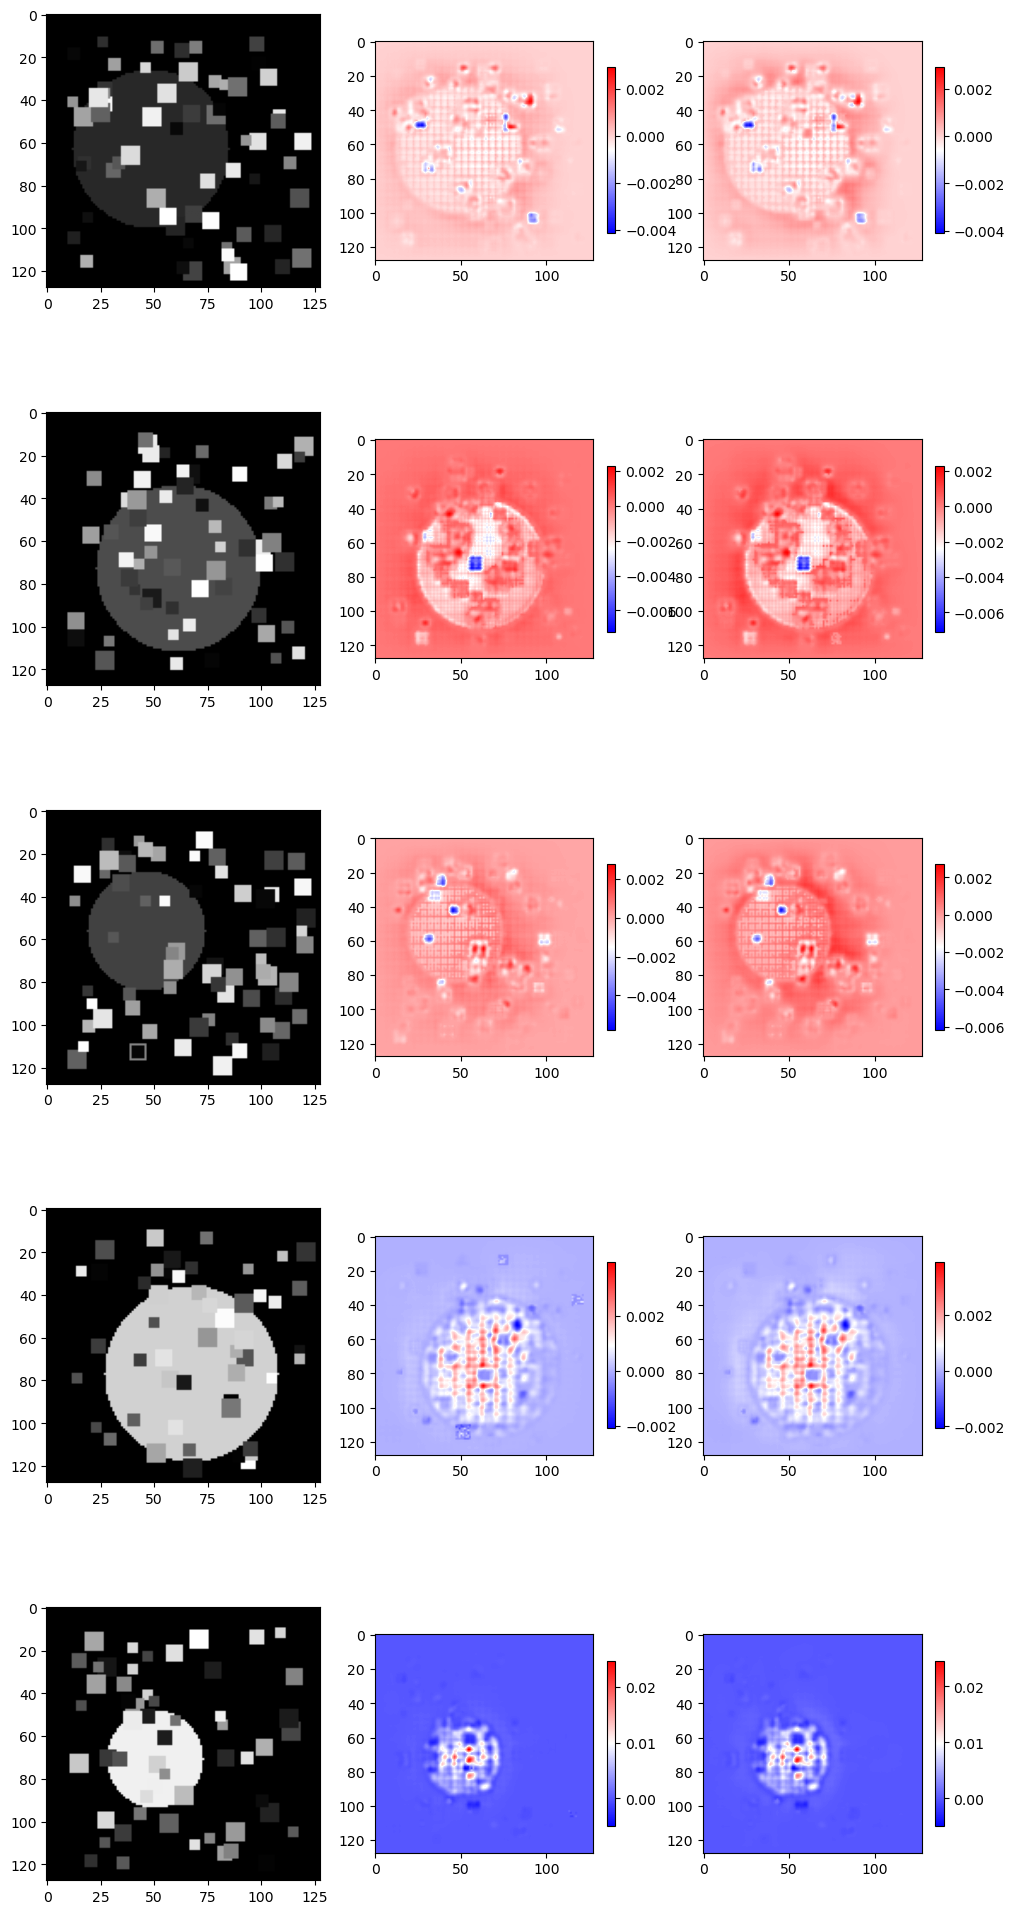

In [18]:
unfair_prior = np.array([90, 110, 140, 160])  #  close to the critical values of 100, 150
unfair_heat_maps = []
plt.figure(figsize=(12, 5*len(image_ids)))
for i, image_id in enumerate(image_ids):
    np.random.seed(image_id)
    explain_img_i, target_i, __ = valid_set.generate_one()
    unfair_map_i = finite_differences_map(res_net, valid_set, target_i.argmax(), explain_img_i, unfairness="unfair", values_prior=unfair_prior)
    unfair_heat_maps.append(unfair_map_i)
    plt.subplot(len(image_ids), 3, 3*i+1)
    plt.imshow(explain_img_i, cmap="gray")
    plt.subplot(len(image_ids), 3, 3*i+2)
    heat_max = np.max(abs(unfair_map_i))
    plt.imshow(unfair_map_i, cmap="bwr", vmax=heat_max, vmin=-heat_max)
    plt.colorbar(shrink=0.5)
    plt.subplot(len(image_ids), 3, 3*i+3)
    heat_max = np.max(abs(heat_maps[i]))
    plt.imshow(heat_maps[i], cmap="bwr", vmax=heat_max, vmin=-heat_max)
    plt.colorbar(shrink=0.5)
plt.show()  # => very similar results, but with a 4x speedup

In [34]:
# regenerate unfair FD maps
unfair_prior = np.array([90, 110, 140, 160])  #  close to the critical values of 100, 150
image_ids = [20_000, 25_000, 30_000, 600_000, 600_001, 227_662, 998_102, 106_758]
unfair_heat_maps = []
#plt.figure(figsize=(12, 5*len(image_ids)))
for i, image_id in enumerate(image_ids):
    np.random.seed(image_id)
    explain_img_i, target_i, __ = valid_set.generate_one()
    unfair_map_i = finite_differences_map(res_net, valid_set, target_i.argmax(), explain_img_i, unfairness="unfair", values_prior=unfair_prior)
    unfair_heat_maps.append(unfair_map_i)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [01:57<00:00,  4.34it/s]


We can do even better by taking the "closest value in a different class" for our prior

100%|██████████| 512/512 [00:47<00:00, 10.86it/s]


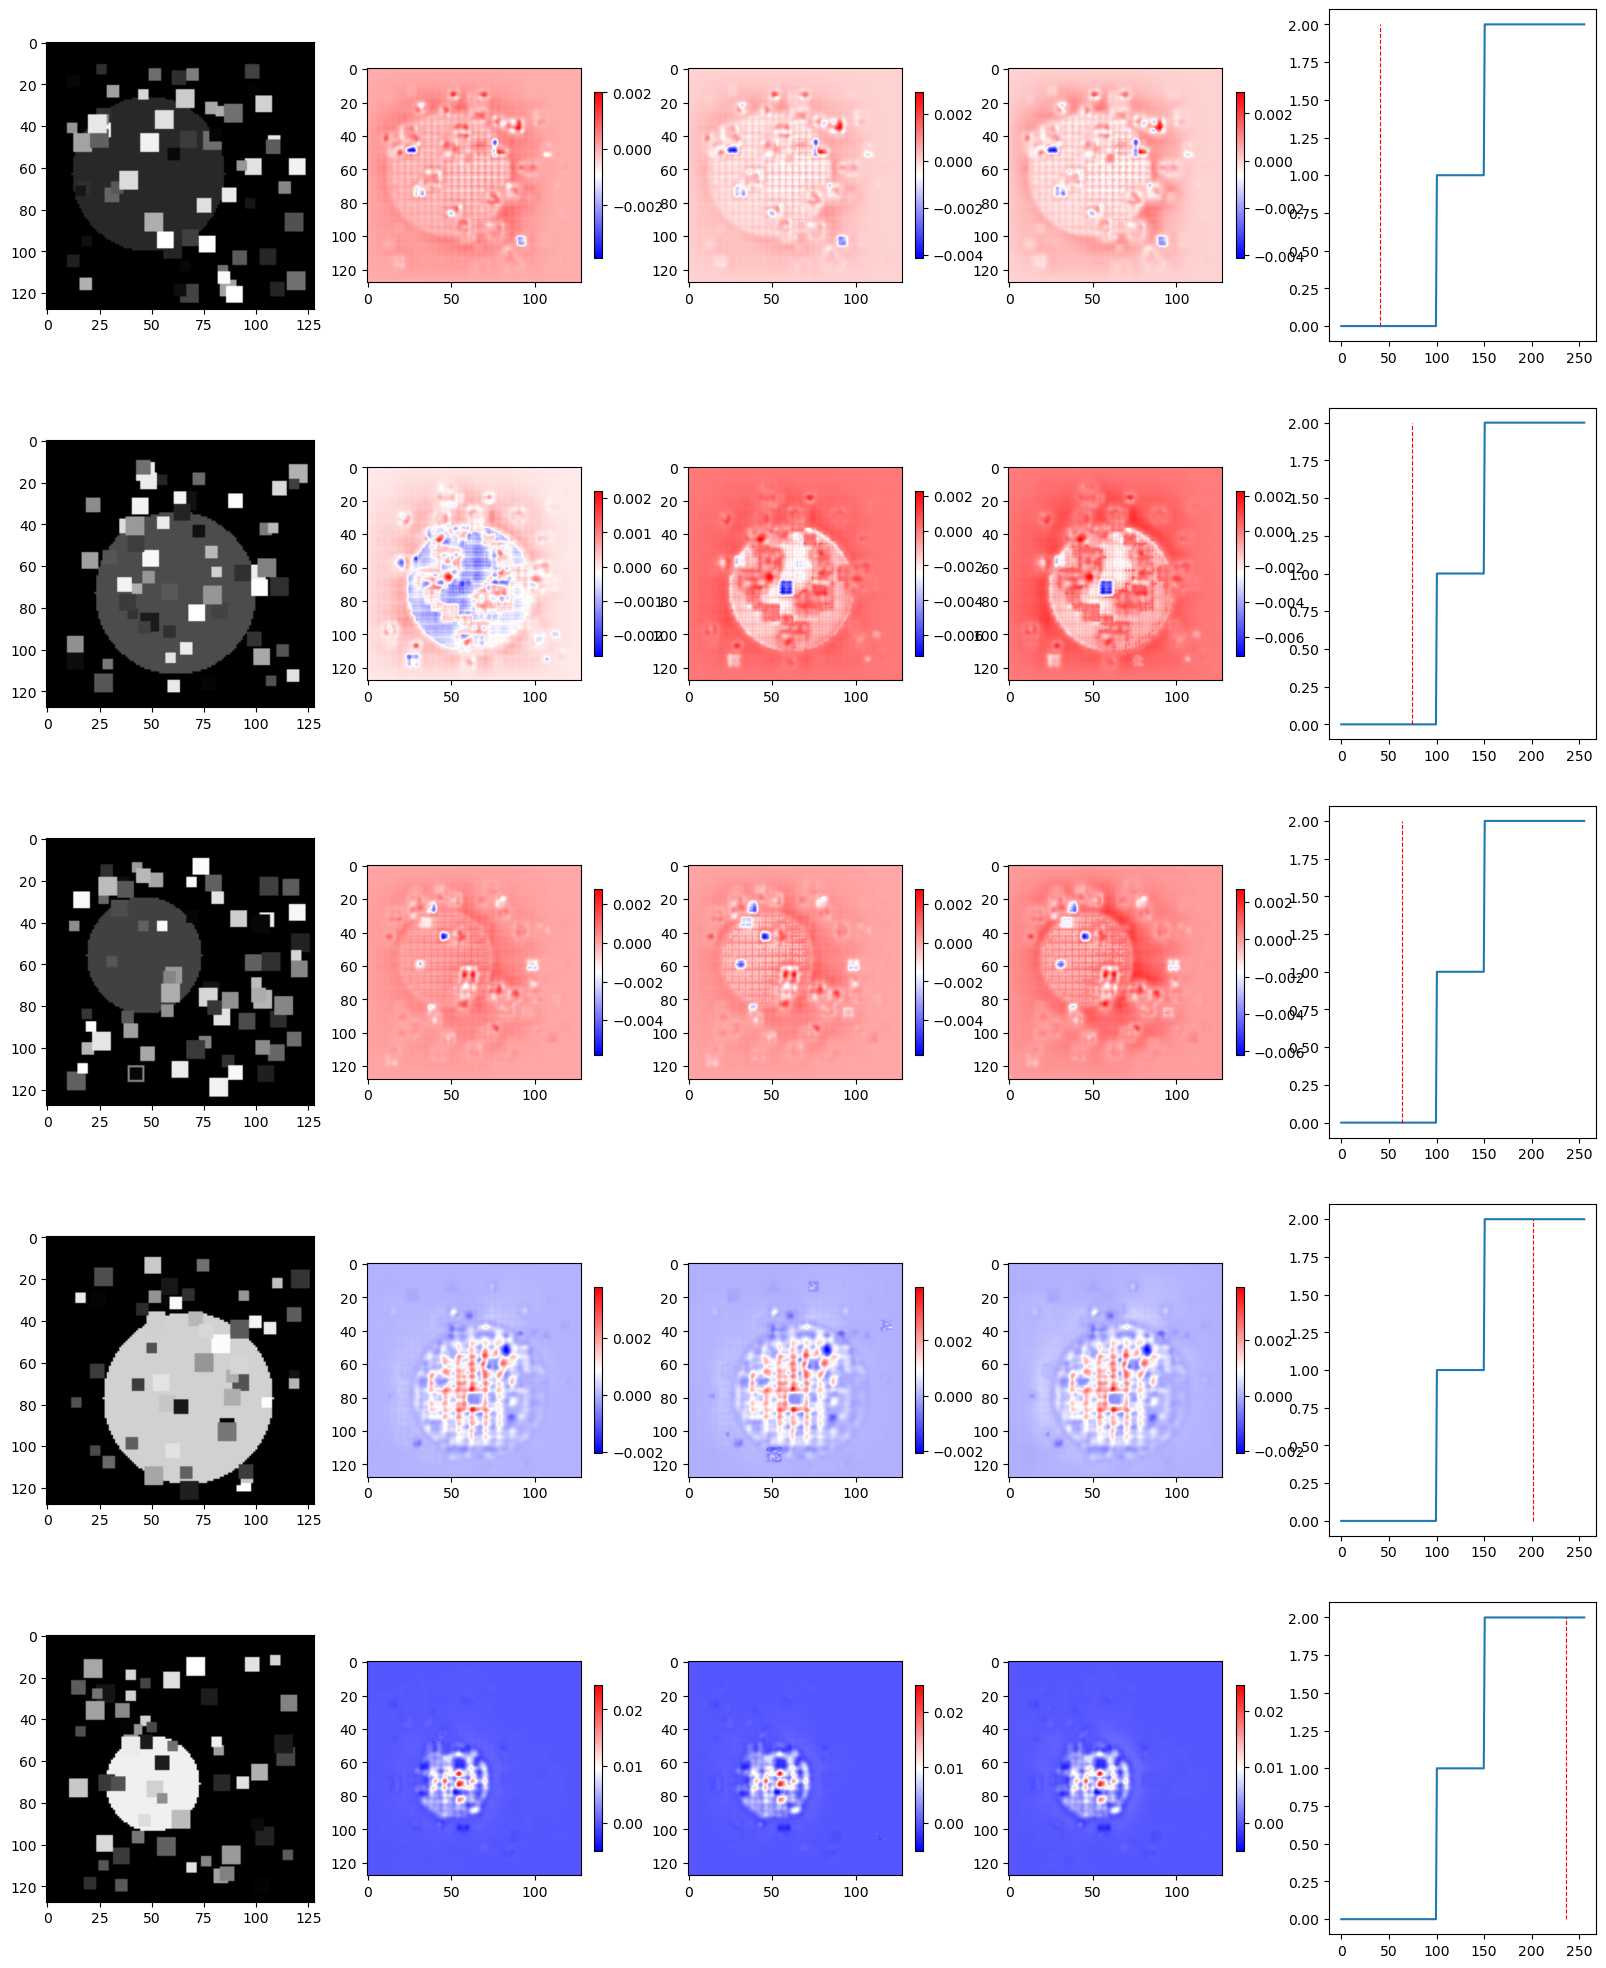

In [51]:
very_unfair_heat_maps = []
plt.figure(figsize=(20, 5*len(image_ids)))
for i, image_id in enumerate(image_ids):
    np.random.seed(image_id)
    explain_img_i, target_i, color_i = valid_set.generate_one()
    very_unfair_map_i = finite_differences_map(res_net, valid_set, target_i.argmax(), explain_img_i, unfairness="very unfair", values_prior=[100, 150])
    very_unfair_heat_maps.append(very_unfair_map_i)
    
    plt.subplot(len(image_ids), 5, 5*i+1)
    if i == 0:
        plt.title("Image")
    plt.imshow(explain_img_i, cmap="gray")
    
    plt.subplot(len(image_ids), 5, 5*i+2)
    if i == 0:
        plt.title("Very unfair FD map")
    heat_max = np.max(abs(very_unfair_map_i))
    plt.imshow(very_unfair_map_i, cmap="bwr", vmax=heat_max, vmin=-heat_max)
    plt.colorbar(shrink=0.5)
    
    plt.subplot(len(image_ids), 5, 5*i+3)
    if i == 0:
        plt.title("Unfair FD map")
    heat_max = np.max(abs(unfair_heat_maps[i]))
    plt.imshow(unfair_heat_maps[i], cmap="bwr", vmax=heat_max, vmin=-heat_max)
    plt.colorbar(shrink=0.5)
    
    plt.subplot(len(image_ids), 5, 5*i+4)
    if i == 0:
        plt.title("FD map")
    heat_max = np.max(abs(heat_maps[i]))
    plt.imshow(heat_maps[i], cmap="bwr", vmax=heat_max, vmin=-heat_max)
    plt.colorbar(shrink=0.5)
    
    plt.subplot(len(image_ids), 5, 5*i+5)
    if i == 0:
        plt.title("Location in color space")
    plt.plot(color_probe, color_class) 
    plt.vlines([color_i], 0, valid_set.num_classes-1, linewidth=0.8,
           colors="r", label="color value",
           linestyles="dashed")
plt.show()  # => somewhat similar results (see image 2), but with an overall ~11x speedup

8it [00:00, 10.11it/s]


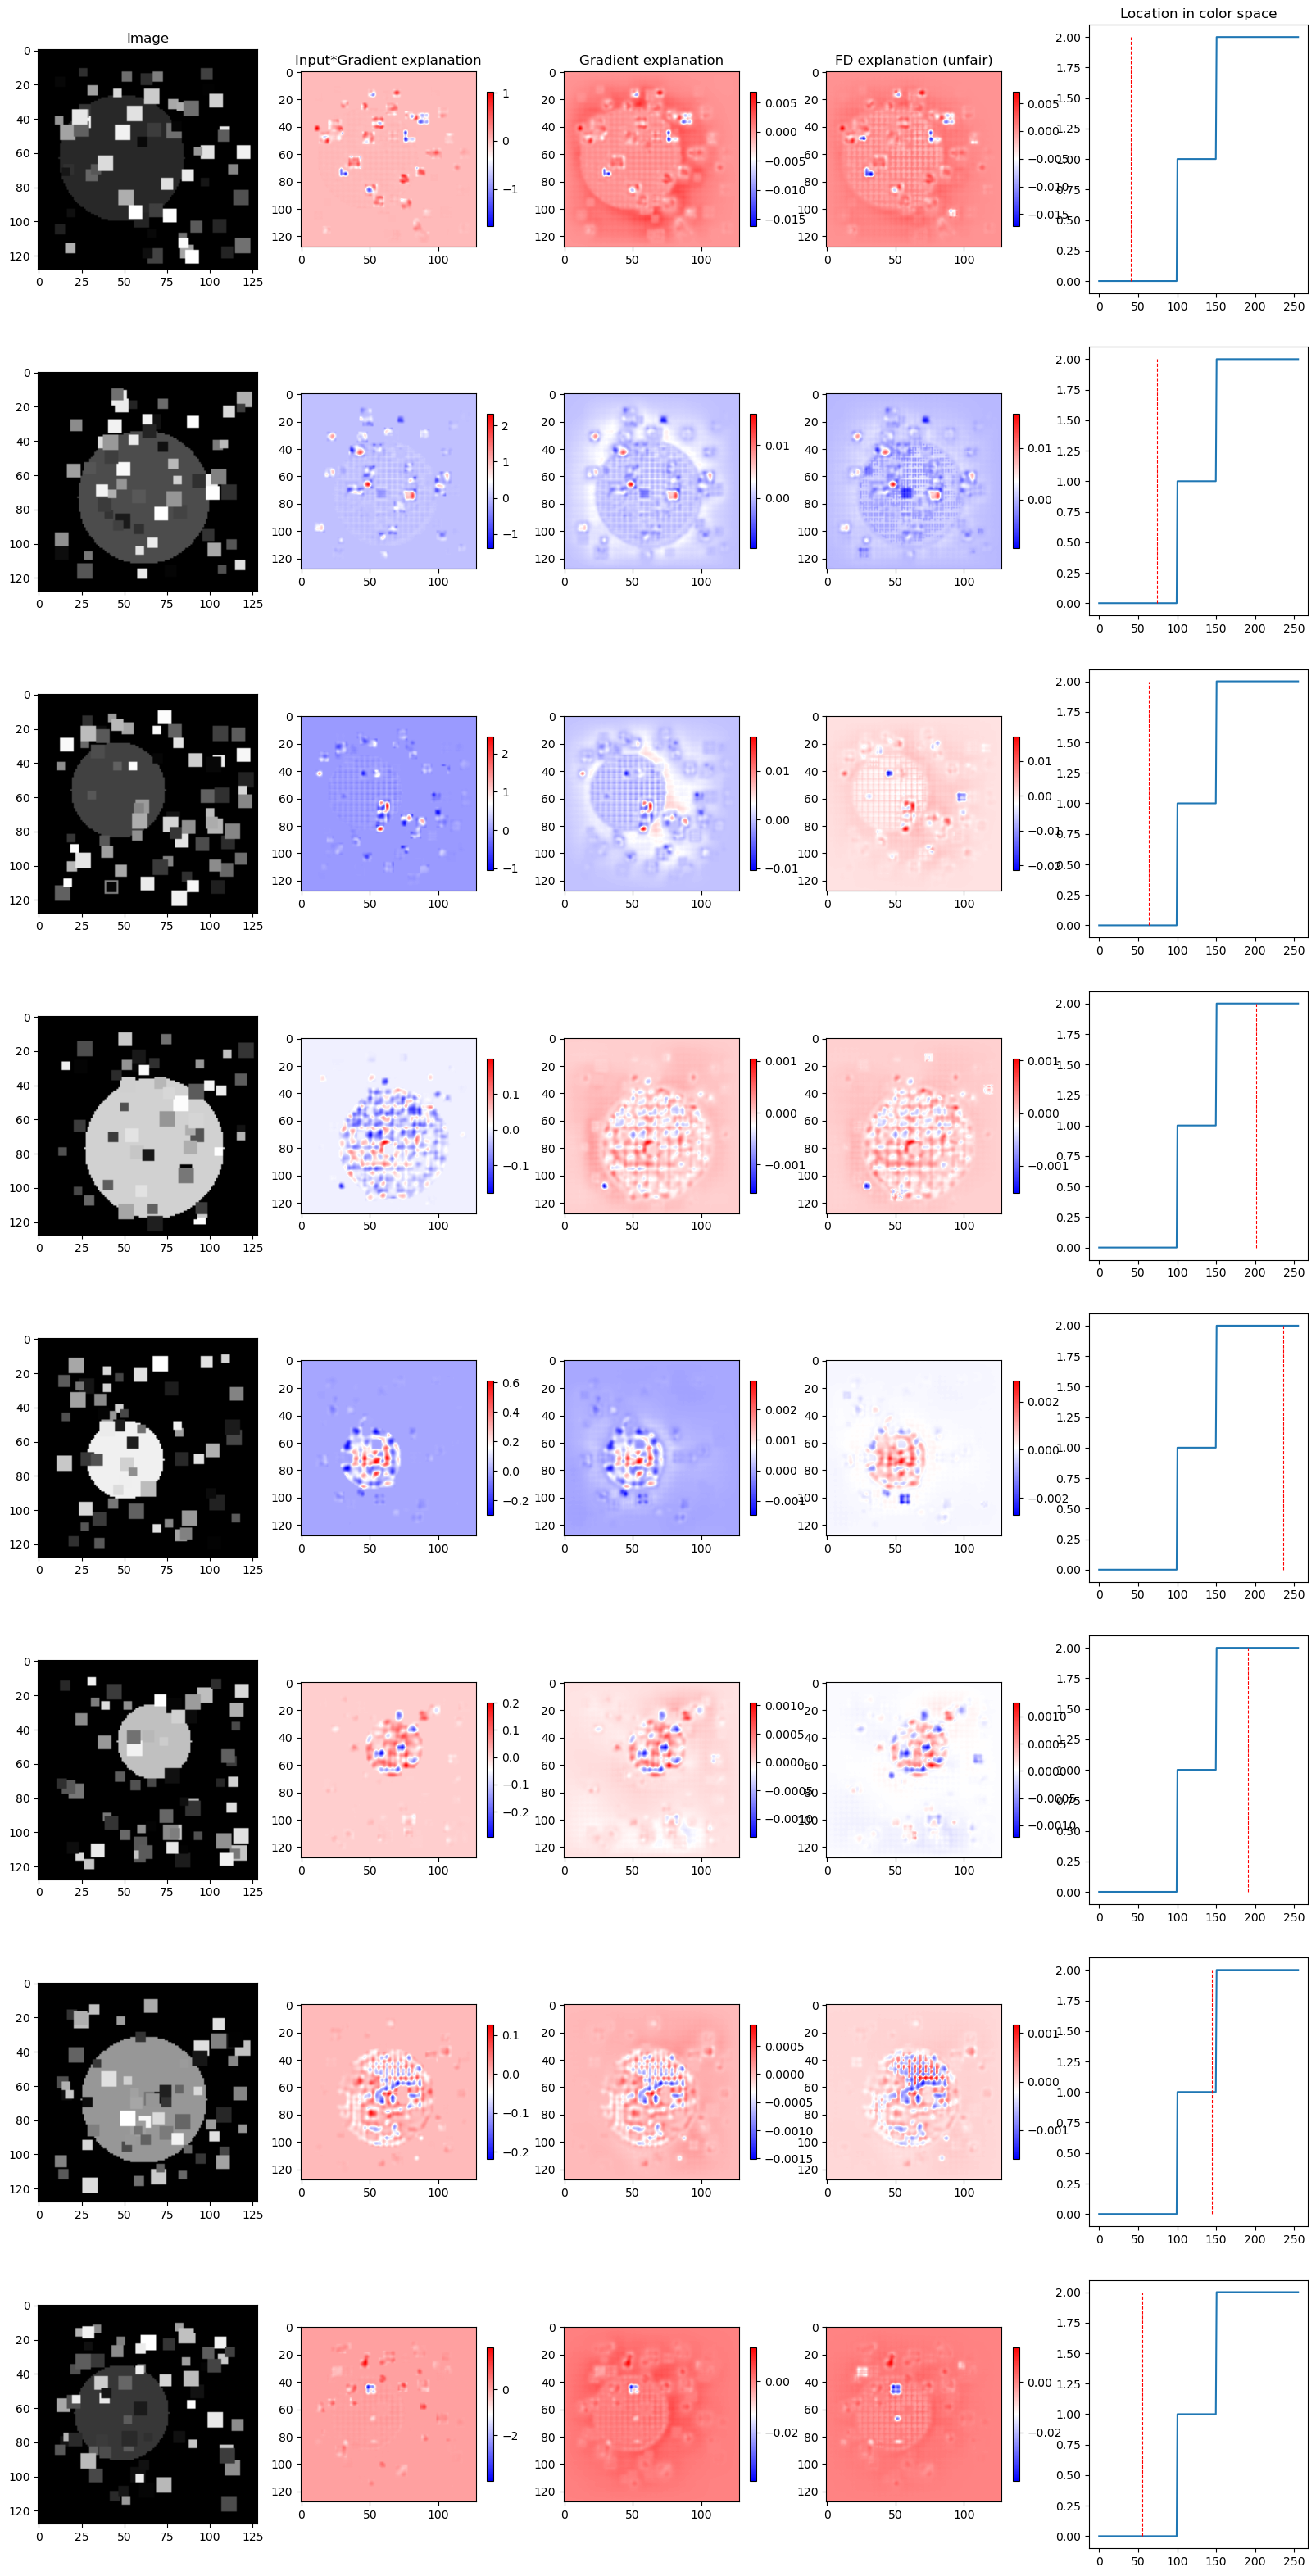

In [37]:
grad_heat_maps = []
plt.figure(figsize=(20, 5*len(image_ids)))
for i, image_id in tqdm(enumerate(image_ids)):
    np.random.seed(image_id)
    explain_img_i, target_i, color_i = valid_set.generate_one()
    batched_explain_img_i = torch.tensor(np.expand_dims(explain_img_i, 0).transpose(0, 3, 1, 2), requires_grad=True).to(device).float()
    output_logit_i = res_net(batched_explain_img_i)[0, target_i.argmax()]
    
    img_grad_i = torch.autograd.grad(output_logit_i, batched_explain_img_i)[0].squeeze().cpu().numpy()
    grad_times_input_i = img_grad_i * np.squeeze(explain_img_i)
    
    plt.subplot(len(image_ids), 5, 5*i+1)
    if i == 0:
        plt.title("Image")
    plt.imshow(explain_img_i, cmap="gray")
    
    plt.subplot(len(image_ids), 5, 5*i+2)
    if i == 0:
        plt.title("Input*Gradient explanation")
    heat_max = np.max(abs(grad_times_input_i))
    plt.imshow(grad_times_input_i, cmap="bwr", vmax=heat_max, vmin=-heat_max)
    plt.colorbar(shrink=0.5)
    
    plt.subplot(len(image_ids), 5, 5*i+3)
    if i == 0:
        plt.title("Gradient explanation")
    heat_max = np.max(abs(img_grad_i))
    plt.imshow(img_grad_i, cmap="bwr", vmax=heat_max, vmin=-heat_max)
    plt.colorbar(shrink=0.5)
    
    plt.subplot(len(image_ids), 5, 5*i+4)
    if i == 0:
        plt.title("FD explanation (unfair)")
    heat_max = np.max(abs(unfair_heat_maps[i]))
    plt.imshow(unfair_heat_maps[i], cmap="bwr", vmax=heat_max, vmin=-heat_max)
    plt.colorbar(shrink=0.5)
    
    plt.subplot(len(image_ids), 5, 5*i+5)
    if i == 0:
        plt.title("Location in color space")
    plt.plot(color_probe, color_class) 
    plt.vlines([color_i], 0, valid_set.num_classes-1, linewidth=0.8,
           colors="r", label="color value",
           linestyles="dashed")
plt.show()
# gradient should be zero, so double check computations, fix scale on cmap

# PCA Direction Tests

In [56]:
def find_pca_directions(dataset, sample_size, scales, strides):
# begin by computing pca directions and d_output_d_alphas
    sample = []
    for _ in range(sample_size):
        sample.append(dataset.generate_one()[0])
    sample = np.array(sample).squeeze()
    im_size = dataset.size
    
    pca_direction_grids = []
    for scale, stride in zip(scales, strides):
        windows = np.lib.stride_tricks.sliding_window_view(sample, (scale,scale), axis=(1,2))
        strided_windows = windows[:, ::stride, ::stride, ...]
                
        xs = np.mgrid[scale:im_size:stride]
        num_grid = xs.shape[0]
        pca_direction_grid = np.zeros((num_grid, num_grid, scale, scale))
        
        pca_fitter = decomposition.PCA(n_components=scale**2, copy=False)
        scale_fitter = StandardScaler()
        for i in tqdm(range(num_grid)):
            for j in range(num_grid):
                # find pca direction for current patch
                pca_selection = strided_windows[:, i, j, ...]
                flattened = pca_selection.reshape(sample_size, -1)
                normalized = scale_fitter.fit_transform(flattened)
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")  # gives pointless zero-division warnings
                    pca_fitter.fit(normalized)
                pca_direction = pca_fitter.components_[0].reshape(scale,scale)
                                
                pca_direction_grid[i,j,...] = pca_direction
        pca_direction_grids.append(pca_direction_grid.copy())    
    return pca_direction_grids
    
def pca_direction_grids(model, dataset, target_class, img, 
                        sample_size=512, scales=[3,5,9,15], 
                        strides=None, pca_direction_grids=None,
                       gaussian=False):
    # begin by computing pca directions and d_output_d_alphas
    model.eval()
    im_size = dataset.size
    if strides is None:
        strides = scales
    if pca_direction_grids is None:
        pca_direction_grids = find_pca_directions(dataset, sample_size, scales, strides)
    d_out_d_alpha_grids = []
    interpolators = []
    indices_grid = np.mgrid[0:im_size, 0:im_size]

    for s, (scale, stride) in enumerate(zip(scales, strides)):
        index_window = np.lib.stride_tricks.sliding_window_view(indices_grid, (scale,scale), axis=(1,2))        
        strided_indices = index_window[:, ::stride, ::stride]
        
        xs = np.mgrid[scale:im_size:stride]
        num_grid = xs.shape[0]
        d_out_d_alpha_grid = np.zeros((num_grid, num_grid))
        for i in tqdm(range(num_grid)):
            for j in range(num_grid):
                # get pca direction for current patch
                pca_direction = pca_direction_grids[s][i,j]
                indices = strided_indices[:, i, j, ...]  # will have to slice these

                # do d_output_d_alpha computation
                alpha = torch.tensor(0.0, requires_grad=True).to(device)
                direction_tensor = torch.tensor(pca_direction).to(device).float()
                img_tensor = torch.tensor(img.transpose(2,0,1)).to(device).float().unsqueeze(0)
                img_tensor[..., indices[0,0,0]:indices[0,-1,-1]+1, indices[1,0,0]:indices[1,-1,-1]+1] += alpha*direction_tensor
                output = model(img_tensor)[0,target_class]
                d_out_d_alpha = torch.autograd.grad(output, alpha)[0]
                
                d_out_d_alpha_grid[i,j] = d_out_d_alpha.detach().cpu().numpy()
        d_out_d_alpha_grids.append(d_out_d_alpha_grid.copy())
        interpolators.append(RegularGridInterpolator((xs, xs), d_out_d_alpha_grid, 
                                                     bounds_error=False, fill_value=None))
    # now, per pixel, interpolate what the d_output_d_alpha value would be if the window
    # were centered at that pixel, then take the max over all possible scales
    saliency_map = np.zeros_like(img)
    scale_wins = [0] * len(scales)
    for i in tqdm(range(im_size)):
        for j in range(im_size):
            best_d_out_d_alpha = 0
            best_scale = -1
            for s in range(len(scales)):
                interp_value = interpolators[s]([i,j])
                if abs(interp_value) >= abs(best_d_out_d_alpha):
                    best_d_out_d_alpha = interp_value
                    best_scale = scale
            saliency_map[i,j] = best_d_out_d_alpha
            scale_wins[s] += 1
    print(scale_wins)
    return saliency_map
# jacobian with respect to window itself

In [57]:
default_scales = [3,5,9,15]
pca_directions_1_stride = find_pca_directions(valid_set, 1024, default_scales, [1]*len(default_scales))
pca_directions_s_stride = find_pca_directions(valid_set, 1024, default_scales, default_scales)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.62it/s]


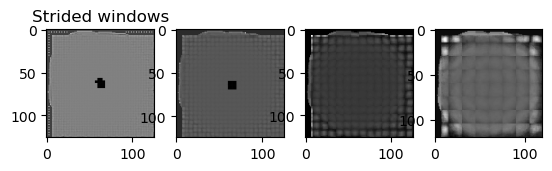

In [47]:
for i, res in enumerate(pca_directions_s_stride):
    compressed_results = np.concatenate(np.concatenate(res, 1), 1)
    plt.subplot(1,len(pca_directions_s_stride),i+1)
    if i == 0:
        plt.title("Strided windows")
    plt.imshow(compressed_results, cmap="gray")

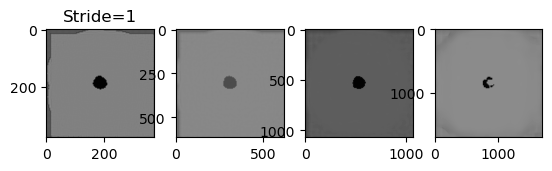

In [48]:
for i, res in enumerate(pca_directions_1_stride):
    compressed_results = np.concatenate(np.concatenate(res, 1), 1)
    plt.subplot(1,len(pca_directions_1_stride),i+1)
    if i == 0:
        plt.title("Stride=1")
    plt.imshow(compressed_results, cmap="gray")

In [41]:
np.random.seed(200_010)
generated_img, label, *__ = valid_set.generate_one()
pca_map_strided = pca_direction_grids(small_net, valid_set, label.argmax(), generated_img, 
                                      pca_direction_grids=pca_directions_s_stride)
pca_map_1_stride = pca_direction_grids(small_net, valid_set, label.argmax(), generated_img, 
                                      pca_direction_grids=pca_directions_1_stride, strides=[1,1,1,1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:07<00:00, 16.96it/s]


[0, 0, 0, 16384]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:07<00:00, 16.73it/s]

[0, 0, 0, 16384]


(1, 2, 128, 128) 1 2


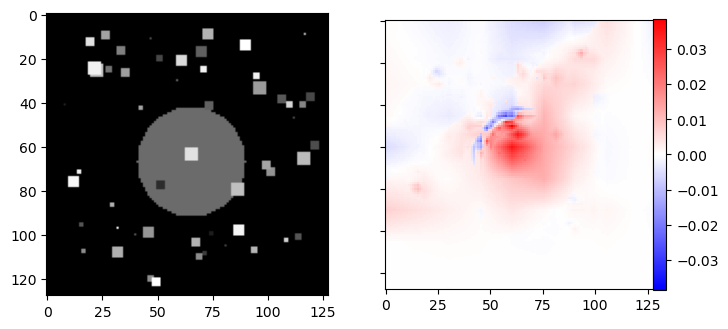

In [21]:
plt_grid_figure([generated_img, result])  # => with strides == scales

(1, 2, 128, 128) 1 2


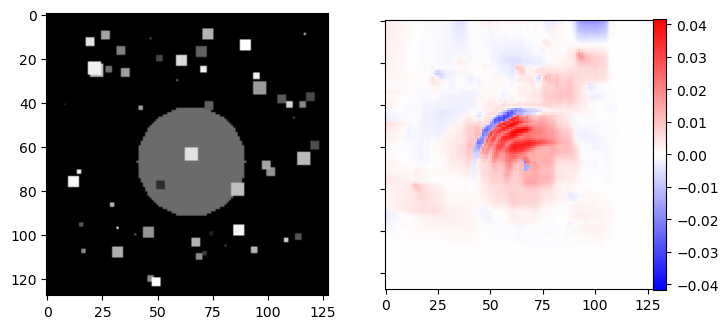

In [25]:
plt_grid_figure([generated_img, result])  # => with strides == 1

In [58]:
seeds = [2123, 40124, 508559, 5019258, 2429852]
pca_map_s_strides = []
pca_map_1_strides = []
explain_imgs = []
for seed in seeds:
    np.random.seed(seed)
    generated_img, label, *__ = valid_set.generate_one()
    pca_map_strided = pca_direction_grids(small_net, valid_set, label.argmax(), generated_img, 
                                          pca_direction_grids=pca_directions_s_stride)
    pca_map_1_stride = pca_direction_grids(small_net, valid_set, label.argmax(), generated_img, 
                                      pca_direction_grids=pca_directions_1_stride, strides=[1,1,1,1])
    explain_imgs.append(generated_img)
    pca_map_s_strides.append(pca_map_strided.copy())
    pca_map_1_strides.append(pca_map_1_stride.copy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:07<00:00, 17.12it/s]


[0, 0, 0, 16384]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:07<00:00, 17.01it/s]


[0, 0, 0, 16384]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:07<00:00, 16.89it/s]


[0, 0, 0, 16384]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:07<00:00, 16.61it/s]


[0, 0, 0, 16384]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:07<00:00, 16.57it/s]


[0, 0, 0, 16384]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:07<00:00, 16.25it/s]


[0, 0, 0, 16384]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:07<00:00, 16.30it/s]


[0, 0, 0, 16384]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:07<00:00, 16.61it/s]


[0, 0, 0, 16384]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:07<00:00, 16.97it/s]


[0, 0, 0, 16384]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:07<00:00, 16.66it/s]

[0, 0, 0, 16384]


(5, 3, 128, 128) 5 3


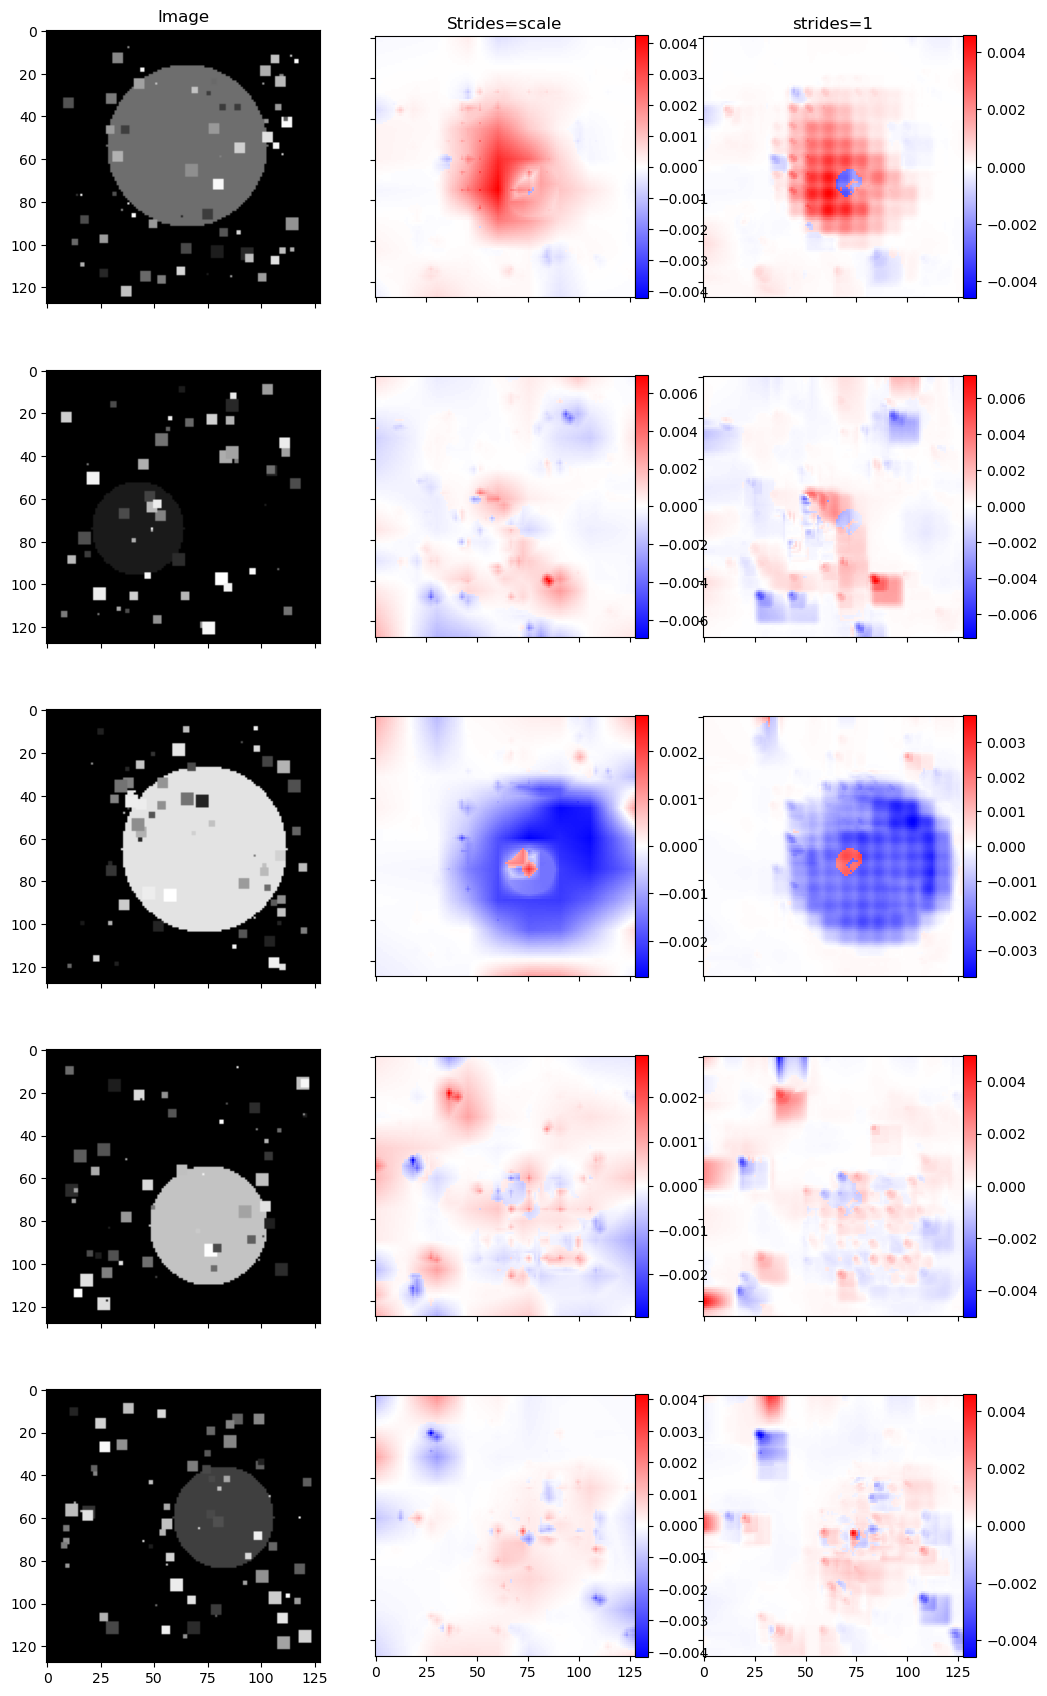

In [63]:
plt_grid_figure([explain_imgs, pca_map_s_strides, pca_map_1_strides], transpose=True, titles=["Image", "Strides=scale", "strides=1"])

In [228]:
# surely this is the best way to do this :)
x = np.arange(400).reshape(5,5,4,4)
from itertools import permutations
for transp_1 in permutations([0,1,2,3]):
    for axis1 in range(3):
        for transp_2 in permutations([0,1,2]):
            for axis2 in range(2):
                for transp_3 in permutations([0,1]):
                    try:
                        t1 = x.transpose(*transp_1)
                        t2 = np.concatenate(t1, axis1)
                        t3 = t2.transpose(*transp_2)
                        t4 = np.concatenate(t3, axis2)
                        t5 = t4.transpose(*transp_3)
                        if t5.shape == (20,20):
                            if all(t5[0,:4] == np.arange(4)) and t5[0,4] == 16:
                                pass
                                #print(transp_1, axis1, transp_2, axis2, transp_3)
                    except:
                        continue
np.concatenate(np.concatenate(x,1),1)

array([[  0,   1,   2,   3,  16,  17,  18,  19,  32,  33,  34,  35,  48,
         49,  50,  51,  64,  65,  66,  67],
       [  4,   5,   6,   7,  20,  21,  22,  23,  36,  37,  38,  39,  52,
         53,  54,  55,  68,  69,  70,  71],
       [  8,   9,  10,  11,  24,  25,  26,  27,  40,  41,  42,  43,  56,
         57,  58,  59,  72,  73,  74,  75],
       [ 12,  13,  14,  15,  28,  29,  30,  31,  44,  45,  46,  47,  60,
         61,  62,  63,  76,  77,  78,  79],
       [ 80,  81,  82,  83,  96,  97,  98,  99, 112, 113, 114, 115, 128,
        129, 130, 131, 144, 145, 146, 147],
       [ 84,  85,  86,  87, 100, 101, 102, 103, 116, 117, 118, 119, 132,
        133, 134, 135, 148, 149, 150, 151],
       [ 88,  89,  90,  91, 104, 105, 106, 107, 120, 121, 122, 123, 136,
        137, 138, 139, 152, 153, 154, 155],
       [ 92,  93,  94,  95, 108, 109, 110, 111, 124, 125, 126, 127, 140,
        141, 142, 143, 156, 157, 158, 159],
       [160, 161, 162, 163, 176, 177, 178, 179, 192, 193, 194, 1

So the question then becomes, how do we search for useful reference images/pixel values in general? We want the distance to be close to the image (small denominator), but also lead to large differences in output logits. This is dangerously close to finding adversarial directions, so we need to make sure we stay in the data manifold => need to establish some sort of distance metric, and potentially a way of detecting whether we are in manifold or not, so we can project into manifold space if needed. This also allows us to switch to a DeepLIFT style type thing.

# Model Optimization Stuff

In [84]:
res_net.save_model_state_dict(optim=optim)

In [55]:
generated_img, _, __ = valid_set.generate_one()
generated_img = torch.tensor(generated_img.transpose(2,0,1)).to(device).unsqueeze(0).float()
for _ in range(1000):
    small_net.forward(generated_img, profile=True)

In [56]:
total = sum(stats.values())  # --> gave 3x speed! (Fast and Accurate Model scaling?)
for k,v in stats.items():    # --> the 3x speedup caused underfitting though, so switched to 2x
    print(k,(100.*v/total))


forward-iter create 0.7632647956937056
forward-conv_bn_relu 0+1 9.707829408522498
forward-conv_bn_relu 0+2 9.175211917502272
forward-is_resid 0 0.5234348135777583
forward-conv_bn_relu 1+1 10.07224881374161
forward-conv_bn_relu 1+2 9.979030105180714
forward-is_resid 1 0.5441818326309913
forward-conv_bn_relu 2+1 10.198438807946037
forward-conv_bn_relu 2+2 9.64393685202165
forward-is_resid 2 0.5300852517080796
forward-conv_bn_relu 3+1 8.217956639384603
forward-conv_bn_relu 3+2 7.757254430058228
forward-is_resid 3 0.5337566043393942
forward-conv_bn_relu 4+1 8.373650279005105
forward-conv_bn_relu 4+2 7.924086874619474
forward-is_resid 4 0.5187519273759398
forward-flatten 0.8387162931162089
forward-relu fc 0 4.199536650957306
forward-final 0.49862770261844946
